In [20]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
from scipy.stats import norm
import statsmodels.formula.api as sm

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [66]:
FHT=pd.read_csv('FHT_ts.csv',index_col=0,parse_dates=[0])
amihud=pd.read_csv('amihud_ts.csv',index_col=0,parse_dates=[0])

In [67]:
# Getting factors
PS=pd.read_csv('PS.csv',parse_dates=[0]).set_index('Month').resample(rule='m',how='last')
factors=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0]).resample(rule='m',how='last')
factors['Pastor and Stambaugh (2003)']=PS['Traded liquidity factor']

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  from IPython.kernel.zmq import kernelapp as app
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  app.launch_new_instance()


In [68]:
data=df.dropna()
data['Intercept']=1

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [72]:
data.head()

,Amihud,LIBOR,FedFunds,TED,FinancialStress,NBER_Recessions,Pastor and Stambaugh (2003),Intercept
2001-01-31,0.014756,6.03875,5.98,0.56,0.880,0.0,0.067953,1
2001-02-28,0.018139,5.62625,5.49,0.32,0.849,0.0,0.042771,1
2001-03-31,0.033065,5.66813,5.31,0.68,0.981,0.0,0.073261,1
2001-04-30,0.022016,4.76875,4.80,0.48,0.976,1.0,0.003903,1
2001-05-31,0.016203,4.22875,4.21,0.44,0.759,1.0,0.027108,1


In [75]:
for f in FHT.columns:
    print f

Equities
Commodities
Currencies
Fixed Income


In [83]:
fht_results={}
fht_results_tstats={}
for f in FHT.columns:
    col=['LIBOR', 'TED', 'FinancialStress','NBER_Recessions','Pastor and Stambaugh (2003)']
    dd=[]
    tt=[]
    r2=[]
    ind=data.index
    for i in range(0,5,1):
        reg=['Intercept']
        d=[0]*int(len(col)+1)
        t=[0]*int(len(col)+1)
        reg.append(col[i])
        res=sm.OLS(FHT[f].ix[ind],data[reg]).fit()
        d[0]=res.params.Intercept
        d[i+1]=res.params[col[i]]
        t[0]=res.tvalues.Intercept
        t[i+1]=res.tvalues[col[i]]
        r2.append(res.rsquared_adj)
        tt.append(t)
        dd.append(d)
    d=[0]*int(len(col)+1)
    t=[0]*int(len(col)+1)
    col.append('Intercept')
    res=sm.OLS(data.Amihud,data[col]).fit()
    d[0]=res.params.Intercept
    t[0]=res.tvalues.Intercept
    r2.append(res.rsquared_adj)
    i=1
    for c in col[:-1]: 
        d[i]=res.params[c] 
        t[i]=res.tvalues[c]
        i=i+1
    tt.append(t)
    dd.append(d)
    ind=col[-1:]+col[:-1]
    x=(pd.DataFrame(dd,columns=ind)*1e11).round(2)
    x['Adjusted R^2']=pd.Series(r2)
    fht_results[f]=x.T.round(2)
    fht_results_tstats[f]=pd.DataFrame(tt,columns=ind).round(2).T

In [82]:
fht_results[f].round(2)

,0,1,2,3,4,5
Intercept,1.370277e+08,1.027432e+08,1.550165e+08,1.307581e+08,1.467901e+08,1.846644e+09
LIBOR,4.697932e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.397409e+07
TED,0.000000e+00,9.908436e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.503124e+08
FinancialStress,0.000000e+00,0.000000e+00,3.893101e+07,0.000000e+00,0.000000e+00,5.891659e+08
NBER_Recessions,0.000000e+00,0.000000e+00,0.000000e+00,1.040270e+08,0.000000e+00,-1.574381e+08
Pastor and Stambaugh (2003),0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.168327e+08,-5.212279e+09
Adjusted R^2,1.000000e-02,3.700000e-01,3.700000e-01,2.700000e-01,2.000000e-02,6.400000e-01


In [84]:
fht_results_tstats[f]

,0,1,2,3,4,5
Intercept,20.79,18.43,38.15,28.62,29.54,22.50
LIBOR,1.81,0.00,0.00,0.00,0.00,-3.24
TED,0.00,10.67,0.00,0.00,0.00,2.67
FinancialStress,0.00,0.00,10.54,0.00,0.00,9.98
NBER_Recessions,0.00,0.00,0.00,8.40,0.00,-0.98
Pastor and Stambaugh (2003),0.00,0.00,0.00,0.00,-2.36,-4.68


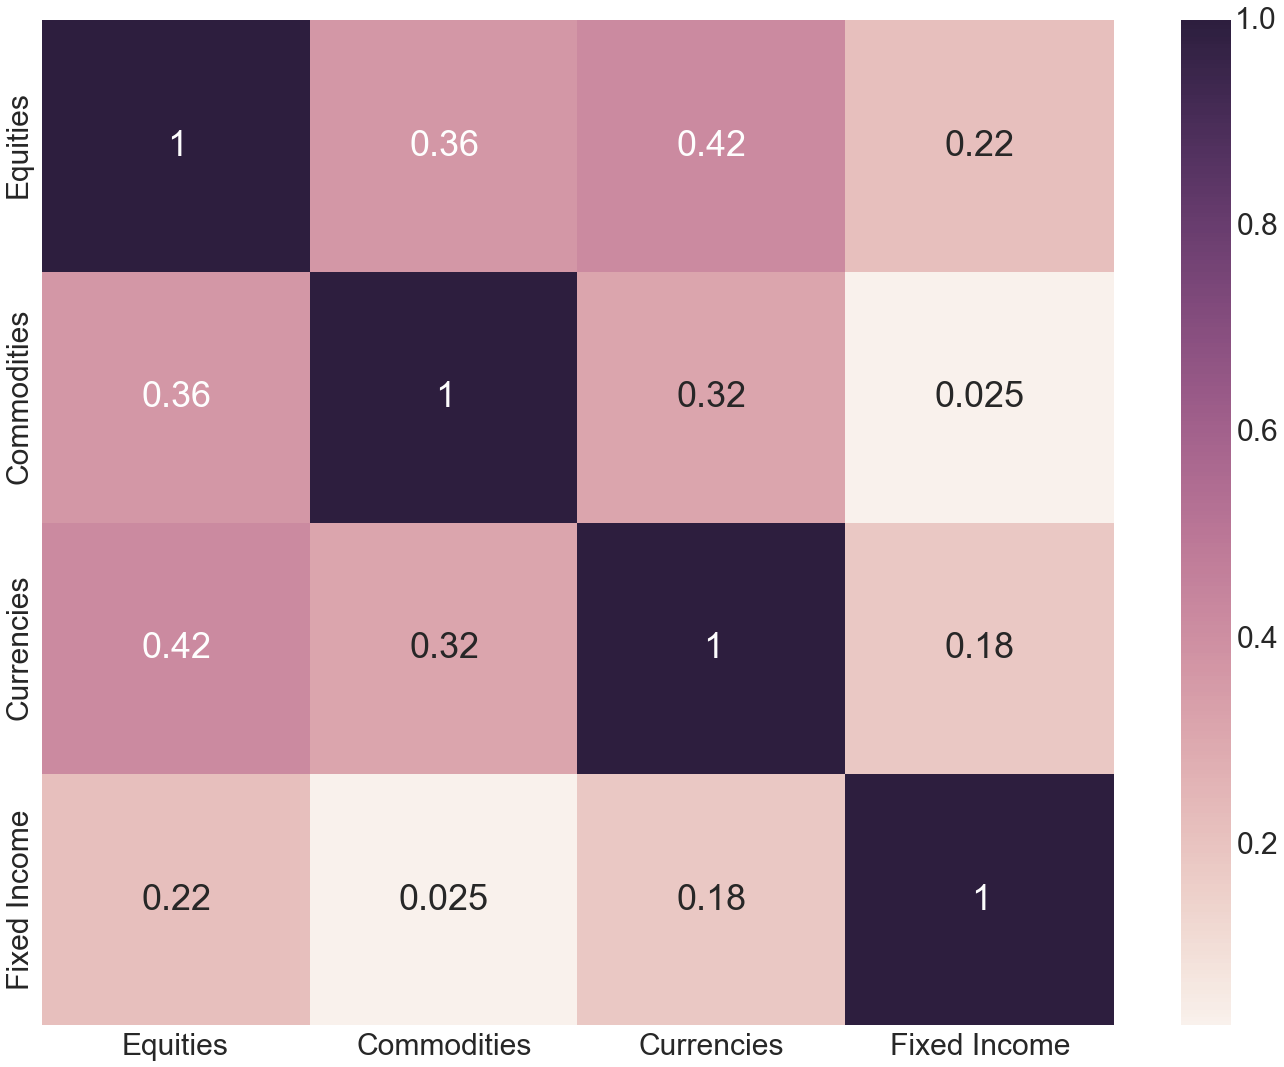

In [94]:
sns.heatmap(FHT.diff().corr(),annot=True)